## **Fake News Classifier Using LSTM**

*In this notebook, I tried to develop deep learning based models. Training was done on feature, which was created by combining informations from all 3 original features (text, title and author). Initially, I used Keras API's Tokenizer class to map sequences of words into integer representation. I began building a binary text classification model using simple neural network framework.*

*Subsequently, I implemented LSTM RNN with Dropout layers. I compared both model by visualizing loss function curves during training and validation process. I found models were tend to be overfitting in both cases.*

*Finally, the best model was found to be fine-tuned logistic regression model developed in prevous notebook, which achieved precision of 96.82% and recall of 98.38%. Next task would be to improve LSTM model by implementing pre-trained Glove for word embedding.*

**Dataset**: https://www.kaggle.com/competitions/fake-news/data/

# Getting Started

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Tensorflow version

import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
## Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#import contractions
import re
import string
import time
import joblib

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
#from nltk.stem.porter import PorterStemmer

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
## Import dataset
#-------------------------------------------------------------------------------
train_df = pd.read_csv('/content/drive/MyDrive/FakeNewsDetection/Data/train.csv')

## Fill nulls by ' '
#-------------------------------------------------------------------------------
train_df = train_df.fillna(' ')

## Strip leading and trailing spaces from text
#-------------------------------------------------------------------------------
train_df['text'] = train_df['text'].str.strip()


## Final combined feature
#-------------------------------------------------------------------------------
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']

## Removing zero length texts from training data
#-------------------------------------------------------------------------------
#train_df['text_length'] = train_df['text'].apply(lambda x: len(x))
#train_df = train_df[train_df['text_length'] > 0]

#Text Preprocessing
---



Here, I used Keras API's Tokenizer class to tokenize the texts, where I set the Out of Vocabulary (OOV) token and the number of words which is the vocabulary size based on word frequency.

In [5]:
## Tokenization
#-------------------------------------------------------------------------------
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000) # Vocabulary size = 6000
tokenizer.fit_on_texts(train_df['all_info']) #  Mapping the tokens to integers


## Encoding the feature set with the integer representations
#--------------------------------------------------------------------------------
sequences_train = tokenizer.texts_to_sequences(train_df['all_info'])

In [6]:
## Sentence length & Vocabulary size
#-------------------------------------------------------------------------------
max_length = 40 # Appropriate sentence length for padding
vocab_size = 6000


## Padding: to get same length of sentences represented by integer sequences
#-------------------------------------------------------------------------------
padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)


## Target variable
#-------------------------------------------------------------------------------
target = train_df['label'].values

In [7]:
## Shape of final feature and target variable

print(f'Feature shape: {padded_train.shape}\n\nTarget shape: {target.shape}')

Feature shape: (20800, 40)

Target shape: (20800,)


In [8]:
## Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

In [9]:
## Shape of training data
print(f'Training feature shape: {X_train.shape}\n\nTraining target shape: {y_train.shape}')

Training feature shape: (16640, 40)

Training target shape: (16640,)


In [10]:
## Checking balance of data

print(f'% data labelled as 1: {round(len(target[target==1])*100/len(target), 2)}')
print(f'\n% data labelled as 0: {round(len(target[target==0])*100/len(target), 2)}')

% data labelled as 1: 50.06

% data labelled as 0: 49.94


**Dataset is completely balanced.**

# Simple Binary Classification Model

I began building a text classification model using a basic deep learning architecture for binary classification.

To optimize training time, I implemented early stopping with a patience value of 15, which means that if there is no improvement in the model's performance over the last 15 epochs, the training process will stop.

 Additionally, I utilized a model checkpoint to save the best performing model during training, ensuring that only the model with the lowest loss is stored (save_best_only=True). By monitoring the loss metric, I selected the "min" mode.

In [11]:
## Path to save best model (using model checkpoint)

best_model_file_name = "/content/drive/MyDrive/FakeNewsDetection/Models/best_model_simple.hdf5"

In [12]:
## Function to assemble a simple neural network for binary classification

def get_simple_model():
    model = Sequential()

    '''Converting input sequences into dense vectors of fixed size'''
    model.add(Embedding(vocab_size, 10, input_length=max_length))

    '''Flattening the output of the embedding layer into a 1-D tensor,
    required before passing it to the dense layer.'''
    model.add(Flatten())

    '''Fully connected layer with a single neuron. It applies the sigmoid activation
    function, commonly used for binary classification problems '''
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
## Apply function to ensemble NN

model = get_simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 10)            60000     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 60,401
Trainable params: 60,401
Non-trainable params: 0
_________________________________________________________________


In [14]:
## Model compilation

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Here, I used precision and recall for metrics to monitor while training and validation
# Binary crossentropy is commonly used loss function for binary classification problem

In [15]:
## Callbacks for early stopping with patience = 15

callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1,
                                         mode="min", restore_best_weights=True),
           keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, verbose=1, save_best_only=True)]

In [16]:
## Model training

model_fit = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test),
                      callbacks=callbacks)

Epoch 1/20
517/520 [============================>.] - ETA: 0s - loss: 0.4235 - precision: 0.8175 - recall: 0.9164
Epoch 1: val_loss improved from inf to 0.21042, saving model to /content/drive/MyDrive/FakeNewsDetection/Models/best_model_simple.hdf5
520/520 [==============================] - 27s 45ms/step - loss: 0.4220 - precision: 0.8182 - recall: 0.9164 - val_loss: 0.2104 - val_precision: 0.8845 - val_recall: 0.9831
Epoch 2/20
517/520 [============================>.] - ETA: 0s - loss: 0.1301 - precision: 0.9399 - recall: 0.9819
Epoch 2: val_loss improved from 0.21042 to 0.13341, saving model to /content/drive/MyDrive/FakeNewsDetection/Models/best_model_simple.hdf5
520/520 [==============================] - 6s 12ms/step - loss: 0.1298 - precision: 0.9400 - recall: 0.9820 - val_loss: 0.1334 - val_precision: 0.9387 - val_recall: 0.9672
Epoch 3/20
510/520 [============================>.] - ETA: 0s - loss: 0.0748 - precision: 0.9683 - recall: 0.9880
Epoch 3: val_loss improved from 0.13341

In [17]:
## Epochs range
range(1, max(model_fit.epoch) + 2)

range(1, 21)

In [18]:
## Training and validation metrics recorded during the training process
model_fit.history.keys()

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])

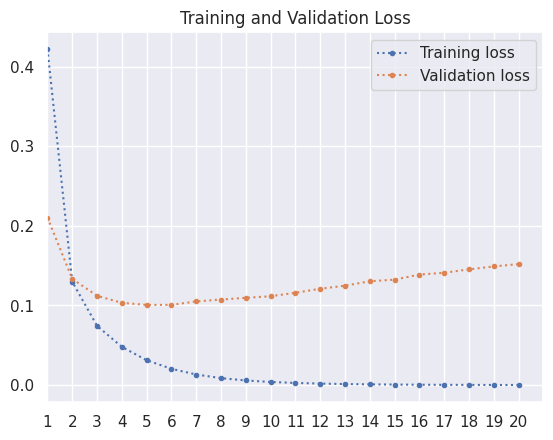

In [19]:
## Visualizing training and validation loss of model during training

metric_to_plot = "loss"
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(model_fit.epoch) + 2])
plt.xticks(range(1, max(model_fit.epoch) + 2))
plt.legend()
plt.show()

**The above plot shows how the values of loss function of the model changes over the course of training epochs.**

**The validation loss was the lowest at the 5th epoch and then the loss was increasing gradually.In summary, the training loss was improving while the validation loss was increasing after the 5th epoch. So, it is evident that model is overfitting.**

**Due to overfitting, model is memorizing the training data and not generalizing well to testing data.**

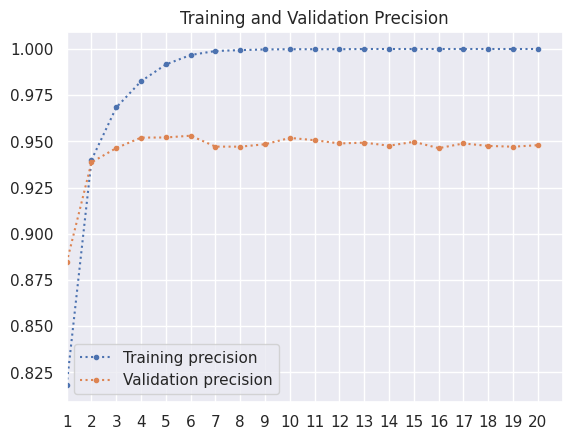

In [20]:
## Visualizing training and validation precision of model during training

metric_to_plot = "precision"
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history[metric_to_plot], ".:", label="Training precision")
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history["val_" + metric_to_plot], ".:", label="Validation precision")
plt.title('Training and Validation Precision')
plt.xlim([1,max(model_fit.epoch) + 2])
plt.xticks(range(1, max(model_fit.epoch) + 2))
plt.legend()
plt.show()

**After the 7th epoch, training precision was quite stagnate. Clearly, precision in validation is lower than precision in training. Again, resembles overfitting model.**

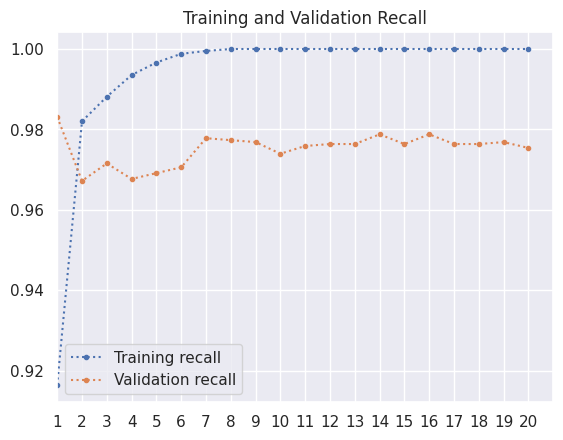

In [21]:
## Visualizing training and validation recall of model during training

metric_to_plot = "recall"
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history[metric_to_plot], ".:", label="Training recall")
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history["val_" + metric_to_plot], ".:", label="Validation recall")
plt.title('Training and Validation Recall')
plt.xlim([1,max(model_fit.epoch) + 2])
plt.xticks(range(1, max(model_fit.epoch) + 2))
plt.legend()
plt.show()

**Similar results could be observed as to precision curve.**

#AUC-ROC curve

The purpose of the AUC-ROC curve is to evaluate and visualize the performance of a classification model at all classification thresholds. AUC stands for Area Under the Curve, and ROC stands for Receiver Operating Characteristic.

The AUC-ROC curve plots the true positive rate (Sensitivity) against the false positive rate (1 - Specificity) at various classification thresholds. Each point on the curve represents a different threshold used for classifying the instances.

It allows you to assess the trade-off between the true positive rate and the false positive rate, and choose an appropriate threshold based on your specific requirements.



In [22]:
## Predictions
#-------------------------------------------------------------------------------
y_pred = model.predict(X_test) # Predicted values by model on test data
base_pred = [[0] for i in range(len(y_test))] # Worst case scenario


## AUROC: Area under the ROC curve
#-------------------------------------------------------------------------------
rand_pred_auc = roc_auc_score(y_test, base_pred)
act_pred_auc = roc_auc_score(y_test, y_pred)

print(f"Random (chance) Prediction: AUROC = {round(rand_pred_auc,2)}")
print(f"\nActual Prediction: AUROC = {round(act_pred_auc,2)}")

130/130 [==============================] - 0s 2ms/step
Random (chance) Prediction: AUROC = 0.5

Actual Prediction: AUROC = 0.99


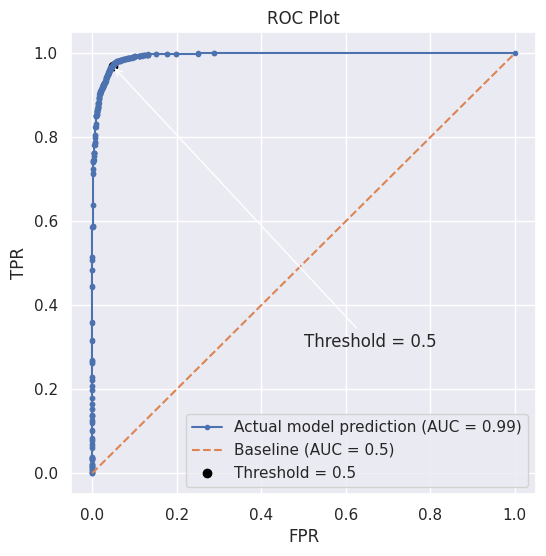

In [23]:
## FPR (False Positive Rate) & TPR (True Positive Rate)
#-------------------------------------------------------------------------------
rand_fpr, rand_tpr, empty= roc_curve(y_test, base_pred)
act_fpr, act_tpr, thresholds = roc_curve(y_test, y_pred)


## Index of the closest threshold value
#-------------------------------------------------------------------------------
thresh = 0.5
# For our problem statement FPR is critical. Therefore, selected threshold >= 0.5

clos_ind = np.argmin(np.abs(thresholds - thresh)) # Closest index to thresh point
clos_fpr, clos_tpr = act_fpr[clos_ind], act_tpr[clos_ind] # Closest FPR & TPR to thresh point


## Plot ROC curve
#-------------------------------------------------------------------------------
plt.figure(figsize= (6,6))
plt.plot(act_fpr, act_tpr, marker= '.', label= f'Actual model prediction (AUC = {round(act_pred_auc,2)})')
plt.plot(rand_fpr, rand_tpr, linestyle= '--', label= f'Baseline (AUC = {round(rand_pred_auc,2)})')
plt.scatter(clos_fpr, clos_tpr, marker= 'o', color= 'black', label= f'Threshold = {thresh}',)
plt.annotate(f'Threshold = {thresh}', xy=(clos_fpr, clos_tpr), xytext=(0.5, 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('ROC Plot')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

**Generally, top-left corner point on AUC-ROC curve represents a high true positive rate (TPR) and a low false positive rate (FPR), indicating a good trade-off between sensitivity and specificity. The corresponding threshold value for this point can be considered as the optimal threshold.**

**In this case, threshold = 0.5 can be considered as optimal threshold.**

In [24]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32") # threshold = 0.5
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

130/130 [==============================] - 0s 2ms/step
Accuracy:  0.9603365384615384
Precision:  0.952132701421801
Recall:  0.9691268692715871
F1 Score:  0.9605546258666028


**This model had an accuracy and f1-score of 96.6%, which is good. But not better than Machine Learning model trained earlier based on logistic regression.**

**So, I tried to implement LSTM model with dropout layer.**

# LSTM Implementation with Dropout layer

LSTM, which stands for Long Short Term Memory, is a special type of recurrent neural network (RNN) designed to capture and understand long-term relationships. It has the ability to retain information over extended periods.

The initial and final layers are identical as they both correspond to the input and output components. In the middle, a Dropout layer has been employed to filter out 30% of the units before proceeding to the LSTM layer, which consists of 100 units.

Following LSTM, I used an additional Dropout layer, succeeded by a fully-connected layer consisting of 64 hidden units. Subsequently, another Dropout layer, and finally fully-connected layer of a single unit. The activation function utilized for this binary classification task was 'Sigmoid'.

In [25]:
## Save best model
#-------------------------------------------------------------------------------
best_model_file_name = "/content/drive/MyDrive/FakeNewsDetection/Models/best_model_LSTM.hdf5"


## Function to ensemble LSTM based neural network
#-------------------------------------------------------------------------------
def get_simple_LSTM_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Dropout(0.3)) # Filtering 30% units
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model


## Callback
#-------------------------------------------------------------------------------
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min",
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, verbose=1, save_best_only=True)]


## Implement LSTM
#-------------------------------------------------------------------------------
model = get_simple_LSTM_model()
print(model.summary())


## Compile model
#-------------------------------------------------------------------------------
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


## Model training
#-------------------------------------------------------------------------------
model_fit = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 10)            60000     
                                                                 
 dropout (Dropout)           (None, 40, 10)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

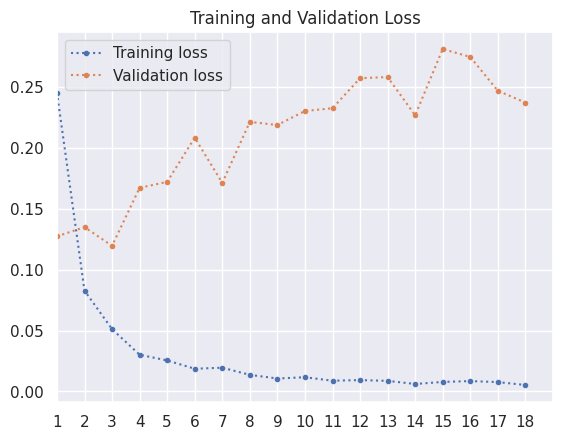

In [26]:
## Visualizing training and validation loss of model during training

metric_to_plot = "loss"
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(model_fit.epoch) + 2), model_fit.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(model_fit.epoch) + 2])
plt.xticks(range(1, max(model_fit.epoch) + 2))
plt.legend()
plt.show()

**Above plot shows that the validation loss had been only increasing, while the training loss was going down due to overfitting.**

#AUC-ROC curve

Followed the same process as done previously.

In [27]:
base_pred = [[0] for i in range(len(y_test))]
y_pred = model.predict(X_test)

rand_pred_auc = roc_auc_score(y_test, base_pred)
act_pred_auc = roc_auc_score(y_test, y_pred)

print(f"Random (chance) Prediction: AUROC = {round(rand_pred_auc,2)}")
print(f"\nActual Prediction: AUROC = {round(act_pred_auc,2)}")

130/130 [==============================] - 1s 3ms/step
Random (chance) Prediction: AUROC = 0.5

Actual Prediction: AUROC = 0.99


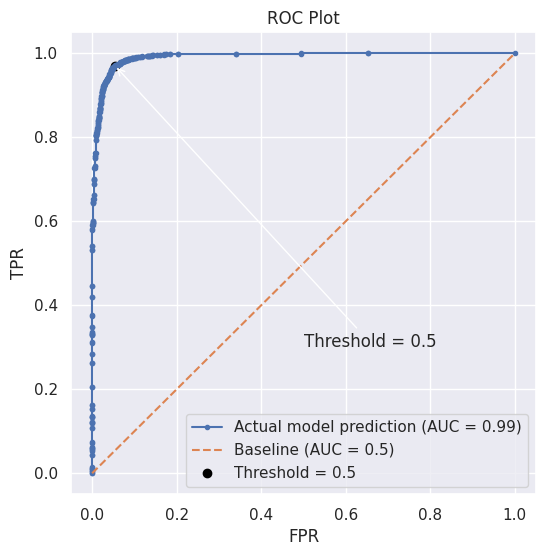

In [28]:
## FPR & TPR

rand_fpr, rand_tpr, empty= roc_curve(y_test, base_pred)
act_fpr, act_tpr, thresholds = roc_curve(y_test, y_pred)


## Index of the closest threshold value

thresh = 0.5

clos_ind = np.argmin(np.abs(thresholds - thresh))
clos_fpr, clos_tpr = act_fpr[clos_ind], act_tpr[clos_ind]



## Plot ROC curve
plt.figure(figsize= (6,6))
plt.plot(act_fpr, act_tpr, marker= '.', label= f'Actual model prediction (AUC = {round(act_pred_auc,2)})')
plt.plot(rand_fpr, rand_tpr, linestyle= '--', label= f'Baseline (AUC = {round(rand_pred_auc,2)})')
plt.scatter(clos_fpr, clos_tpr, marker= 'o', color= 'black', label= f'Threshold = {thresh}',)
plt.annotate(f'Threshold = {thresh}', xy=(clos_fpr, clos_tpr), xytext=(0.5, 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('ROC Plot')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

**Same threshold point, equal to 0.5.**

In [29]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

130/130 [==============================] - 1s 4ms/step
Accuracy:  0.9584134615384615
Precision:  0.9472693032015066
Recall:  0.9705740472744814
F1 Score:  0.9587800810102455


**No significant improvement in this model.**

# Conclusion

The best model was found to be fine-tuned logistic regression model developed in prevous notebook, which achieved precision of 96.82% and recall of 98.38%.

# Further Works
For improving LSTM based model, an experiment can be done with pre-trained word-embeddings, like GloVe. GloVe is an unsupervised ML algorithm and it generates vector representations for words.